<a href="https://colab.research.google.com/github/lucas-larsson/II142X/blob/main/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# II142X Degree project  VGG16 vs VGG32 a depper dive

- Alex Lindberg : alex5@kth.se
- Lucas Larsson : lulars@kth.se

In [2]:
# make sure we are running NVIDIA GPU V 100, specifically Tesla V100-SXM2-16GB
!nvidia-smi

Sun Apr 21 14:19:11 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-SXM2-16GB           Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Imports and setup

In [1]:
import torch
import torchvision
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Clone the git repos to accsess custom functions

!git clone https://github.com/lucas-larsson/II142X.git
%cd II142X/

Cloning into 'II142X'...
remote: Enumerating objects: 58, done.
remote: Counting objects: 100% (58/58), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 58 (delta 17), reused 36 (delta 12), pack-reused 0
Receiving objects: 100% (58/58), 1.92 MiB | 13.22 MiB/s, done.
Resolving deltas: 100% (17/17), done.
/content/II142X


In [4]:
# From local helper files

from helpers.evaluation import set_all_seeds, compute_confusion_matrix
from helpers.training import train_model
from helpers.plotting import plot_training_loss, plot_accuracy, show_examples, plot_confusion_matrix
from helpers.data_importing import get_dataloaders_cifar10, UnNormalize, save_model, save_metrics
from helpers.plotting import plot_metric

## Settings and Dataset

In [5]:
RANDOM_SEED = 123
BATCH_SIZE = 256
NUM_EPOCHS = 50
set_all_seeds(RANDOM_SEED)
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
results_dir = '/content/drive/My Drive/Colab Notebooks/II142X-Results'

In [6]:
import multiprocessing as mp

if __name__ == '__main__':
    mp.set_start_method('spawn')  # or 'forkserver'
    # Your multiprocessing code here


In [7]:
##########################
### CIFAR-10 DATASET
##########################

##  VGG 16, resize to 64x64

train_transforms_64 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.RandomCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms_64 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((70, 70)),
    torchvision.transforms.CenterCrop((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader_64, valid_loader_64, test_loader_64 = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms_64,
    test_transforms=test_transforms_64,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader_64:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break

## VGG 23 resize to 128x128

train_transforms_128 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((140, 140)),
    torchvision.transforms.RandomCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transforms_128 = torchvision.transforms.Compose([
    torchvision.transforms.Resize((140, 140)),
    torchvision.transforms.CenterCrop((128, 128)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_loader_128, valid_loader_128, test_loader_128 = get_dataloaders_cifar10(
    batch_size=BATCH_SIZE,
    validation_fraction=0.1,
    train_transforms=train_transforms_128,
    test_transforms=test_transforms_128,
    num_workers=2)

# Checking the dataset
for images, labels in train_loader_128:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:10])
    break


100%|██████████| 170498071/170498071 [00:03<00:00, 54099586.59it/s]


Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([256, 3, 64, 64])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([4, 7, 4, 6, 2, 6, 9, 7, 3, 0])
Files already downloaded and verified
Image batch dimensions: torch.Size([256, 3, 128, 128])
Image label dimensions: torch.Size([256])
Class labels of 10 examples: tensor([9, 7, 0, 5, 6, 9, 1, 7, 4, 5])


## Training and Testing

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch: 001/050 | Batch 0000/0175 | Loss: 3.9605
Epoch: 001/050 | Batch 0100/0175 | Loss: 2.3069
Epoch: 001/050 | Train Acc: 24.24% | Validation Acc: 24.02% | Precision: 0.2628 | Recall: 0.2391 | F1: 0.1862
Epoch: 002/050 | Batch 0000/0175 | Loss: 1.9924
Epoch: 002/050 | Batch 0100/0175 | Loss: 1.7911
Epoch: 002/050 | Train Acc: 39.42% | Validation Acc: 39.18% | Precision: 0.3891 | Recall: 0.3910 | F1: 0.3523
Epoch: 003/050 | Batch 0000/0175 | Loss: 1.5843
Epoch: 003/050 | Batch 0100/0175 | Loss: 1.4848
Epoch: 003/050 | Train Acc: 45.42% | Validation Acc: 45.66% | Precision: 0.4911 | Recall: 0.4597 | F1: 0.4215
Epoch: 004/050 | Batch 0000/0175 | Loss: 1.4147
Epoch: 004/050 | Batch 0100/0175 | Loss: 1.3250
Epoch: 004/050 | Train Acc: 57.13% | Validation Acc: 58.04% | Precision: 0.5957 | Recall: 0.5787 | F1: 0.5713
Epoch: 005/050 | Batch 0000/0175 | Loss: 1.1966
Epoch: 005/050 | Batch 0100/0175 | Loss: 1.3266
Epoch: 005/050 | Train Acc: 61.59% | Validation Acc: 61.68% | Precision: 0.6406 

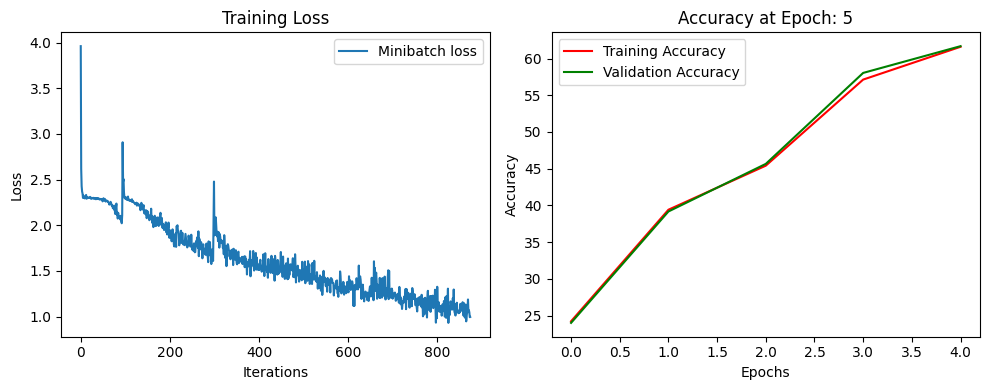

Epoch: 006/050 | Batch 0000/0175 | Loss: 1.1042
Epoch: 006/050 | Batch 0100/0175 | Loss: 1.0633
Epoch: 006/050 | Train Acc: 67.79% | Validation Acc: 67.70% | Precision: 0.6877 | Recall: 0.6791 | F1: 0.6722
Epoch: 007/050 | Batch 0000/0175 | Loss: 0.9962
Epoch: 007/050 | Batch 0100/0175 | Loss: 0.7832
Epoch: 007/050 | Train Acc: 71.99% | Validation Acc: 71.50% | Precision: 0.7333 | Recall: 0.7141 | F1: 0.7141
Epoch: 008/050 | Batch 0000/0175 | Loss: 0.8606
Epoch: 008/050 | Batch 0100/0175 | Loss: 0.7842
Epoch: 008/050 | Train Acc: 75.13% | Validation Acc: 73.84% | Precision: 0.7527 | Recall: 0.7381 | F1: 0.7369
Epoch: 009/050 | Batch 0000/0175 | Loss: 0.6700
Epoch: 009/050 | Batch 0100/0175 | Loss: 0.7103
Epoch: 009/050 | Train Acc: 77.53% | Validation Acc: 76.18% | Precision: 0.7748 | Recall: 0.7615 | F1: 0.7620
Epoch: 010/050 | Batch 0000/0175 | Loss: 0.6344
Epoch: 010/050 | Batch 0100/0175 | Loss: 0.6154
Epoch: 010/050 | Train Acc: 79.00% | Validation Acc: 77.26% | Precision: 0.7910 

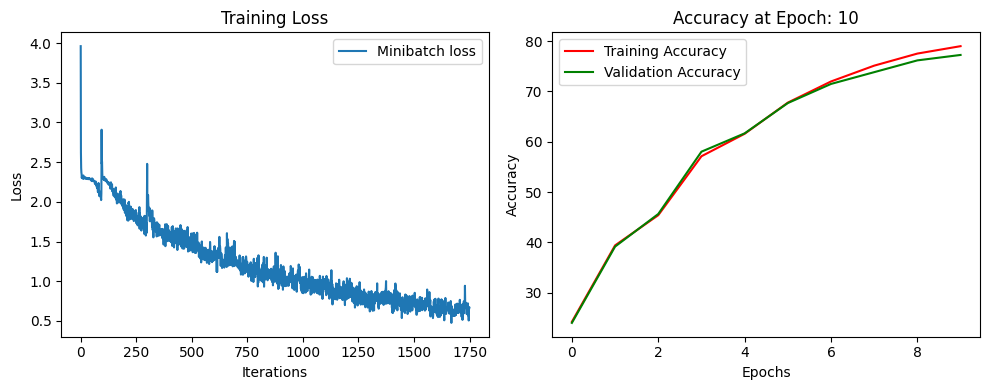

Epoch: 011/050 | Batch 0000/0175 | Loss: 0.5968
Epoch: 011/050 | Batch 0100/0175 | Loss: 0.5536
Epoch: 011/050 | Train Acc: 81.04% | Validation Acc: 78.18% | Precision: 0.7943 | Recall: 0.7819 | F1: 0.7808
Epoch: 012/050 | Batch 0000/0175 | Loss: 0.5685
Epoch: 012/050 | Batch 0100/0175 | Loss: 0.5371
Epoch: 012/050 | Train Acc: 84.15% | Validation Acc: 79.94% | Precision: 0.8023 | Recall: 0.8005 | F1: 0.7971
Epoch: 013/050 | Batch 0000/0175 | Loss: 0.5382
Epoch: 013/050 | Batch 0100/0175 | Loss: 0.4787
Epoch: 013/050 | Train Acc: 84.58% | Validation Acc: 79.84% | Precision: 0.8070 | Recall: 0.7998 | F1: 0.7975
Epoch: 014/050 | Batch 0000/0175 | Loss: 0.4349
Epoch: 014/050 | Batch 0100/0175 | Loss: 0.4250
Epoch: 014/050 | Train Acc: 87.27% | Validation Acc: 81.78% | Precision: 0.8222 | Recall: 0.8192 | F1: 0.8169
Epoch: 015/050 | Batch 0000/0175 | Loss: 0.3734
Epoch: 015/050 | Batch 0100/0175 | Loss: 0.5290
Epoch: 015/050 | Train Acc: 88.56% | Validation Acc: 81.84% | Precision: 0.8268 

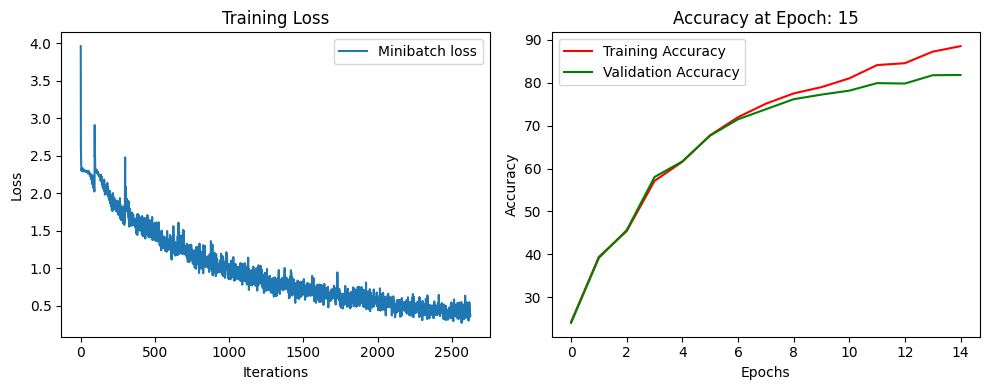

Epoch: 016/050 | Batch 0000/0175 | Loss: 0.3598
Epoch: 016/050 | Batch 0100/0175 | Loss: 0.3448
Epoch: 016/050 | Train Acc: 88.13% | Validation Acc: 81.12% | Precision: 0.8210 | Recall: 0.8112 | F1: 0.8107
Epoch: 017/050 | Batch 0000/0175 | Loss: 0.3340
Epoch: 017/050 | Batch 0100/0175 | Loss: 0.4022
Epoch: 017/050 | Train Acc: 90.48% | Validation Acc: 82.94% | Precision: 0.8398 | Recall: 0.8296 | F1: 0.8315
Epoch: 018/050 | Batch 0000/0175 | Loss: 0.2926
Epoch: 018/050 | Batch 0100/0175 | Loss: 0.3230
Epoch: 018/050 | Train Acc: 92.13% | Validation Acc: 83.20% | Precision: 0.8350 | Recall: 0.8319 | F1: 0.8330
Epoch: 019/050 | Batch 0000/0175 | Loss: 0.2624
Epoch: 019/050 | Batch 0100/0175 | Loss: 0.3232
Epoch: 019/050 | Train Acc: 91.84% | Validation Acc: 82.62% | Precision: 0.8311 | Recall: 0.8271 | F1: 0.8249
Epoch: 020/050 | Batch 0000/0175 | Loss: 0.2524
Epoch: 020/050 | Batch 0100/0175 | Loss: 0.2559
Epoch: 020/050 | Train Acc: 92.62% | Validation Acc: 82.48% | Precision: 0.8313 

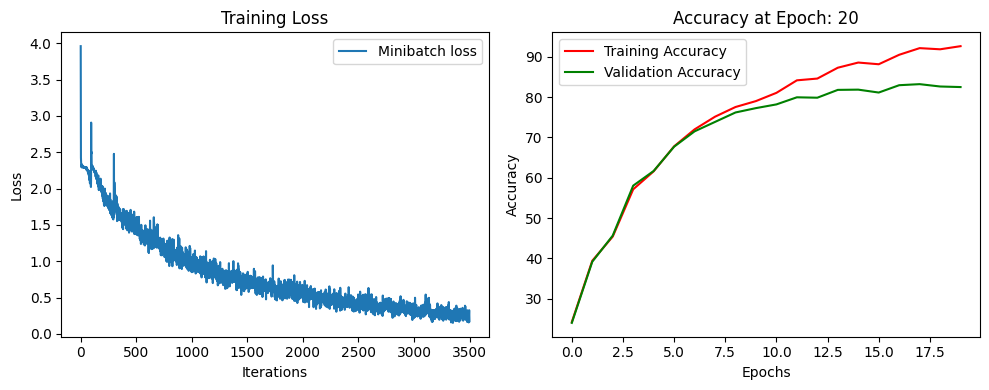

Epoch: 021/050 | Batch 0000/0175 | Loss: 0.2246
Epoch: 021/050 | Batch 0100/0175 | Loss: 0.2150
Epoch: 021/050 | Train Acc: 94.52% | Validation Acc: 83.70% | Precision: 0.8377 | Recall: 0.8379 | F1: 0.8360
Epoch: 022/050 | Batch 0000/0175 | Loss: 0.1435
Epoch: 022/050 | Batch 0100/0175 | Loss: 0.1823
Epoch: 022/050 | Train Acc: 94.65% | Validation Acc: 83.56% | Precision: 0.8376 | Recall: 0.8361 | F1: 0.8355
Epoch: 023/050 | Batch 0000/0175 | Loss: 0.2065
Epoch: 023/050 | Batch 0100/0175 | Loss: 0.1332
Epoch: 023/050 | Train Acc: 95.40% | Validation Acc: 83.62% | Precision: 0.8388 | Recall: 0.8368 | F1: 0.8355
Epoch: 024/050 | Batch 0000/0175 | Loss: 0.1725
Epoch: 024/050 | Batch 0100/0175 | Loss: 0.2286
Epoch: 024/050 | Train Acc: 96.18% | Validation Acc: 83.70% | Precision: 0.8373 | Recall: 0.8379 | F1: 0.8362
Epoch: 025/050 | Batch 0000/0175 | Loss: 0.1437
Epoch: 025/050 | Batch 0100/0175 | Loss: 0.1873
Epoch: 025/050 | Train Acc: 95.44% | Validation Acc: 83.18% | Precision: 0.8364 

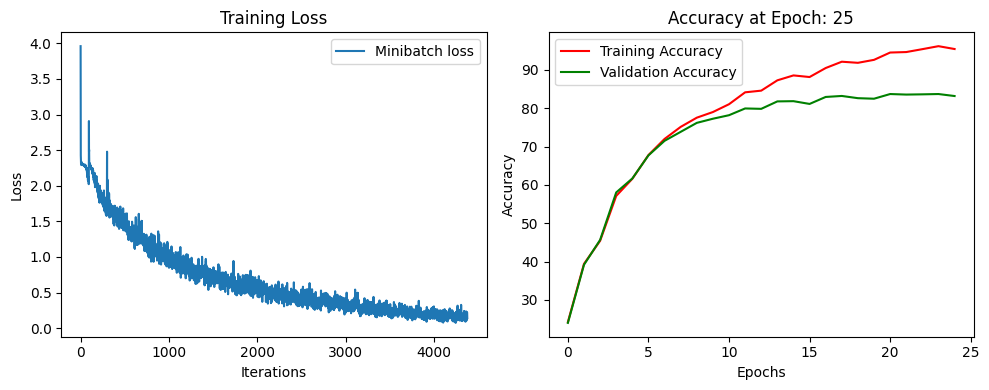

Epoch: 026/050 | Batch 0000/0175 | Loss: 0.1389
Epoch: 026/050 | Batch 0100/0175 | Loss: 0.1905
Epoch: 026/050 | Train Acc: 97.21% | Validation Acc: 84.00% | Precision: 0.8453 | Recall: 0.8410 | F1: 0.8412
Epoch: 027/050 | Batch 0000/0175 | Loss: 0.0829
Epoch: 027/050 | Batch 0100/0175 | Loss: 0.1312
Epoch: 027/050 | Train Acc: 96.87% | Validation Acc: 83.88% | Precision: 0.8401 | Recall: 0.8387 | F1: 0.8383
Epoch: 028/050 | Batch 0000/0175 | Loss: 0.1092
Epoch: 028/050 | Batch 0100/0175 | Loss: 0.1149
Epoch: 028/050 | Train Acc: 97.16% | Validation Acc: 83.70% | Precision: 0.8399 | Recall: 0.8375 | F1: 0.8370
Epoch: 029/050 | Batch 0000/0175 | Loss: 0.0887
Epoch: 029/050 | Batch 0100/0175 | Loss: 0.1764
Epoch: 029/050 | Train Acc: 96.86% | Validation Acc: 83.22% | Precision: 0.8376 | Recall: 0.8319 | F1: 0.8328
Epoch: 030/050 | Batch 0000/0175 | Loss: 0.1249
Epoch: 030/050 | Batch 0100/0175 | Loss: 0.0917
Epoch: 030/050 | Train Acc: 96.62% | Validation Acc: 83.80% | Precision: 0.8427 

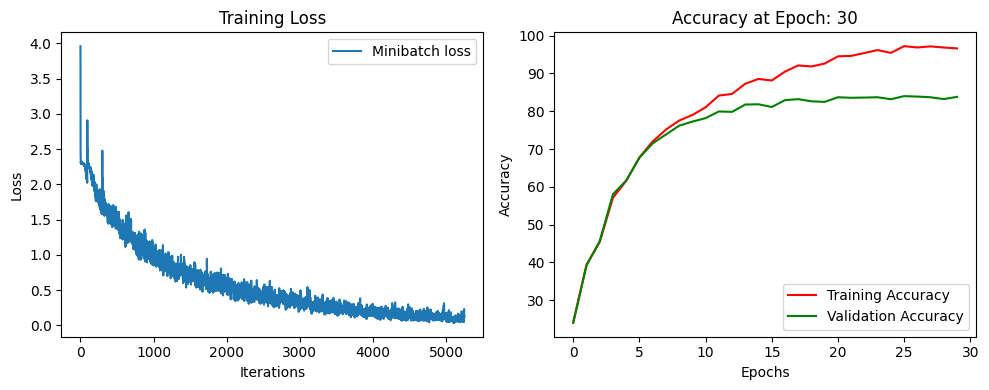

Epoch: 031/050 | Batch 0000/0175 | Loss: 0.1218
Epoch: 031/050 | Batch 0100/0175 | Loss: 0.1011
Epoch: 031/050 | Train Acc: 97.44% | Validation Acc: 83.82% | Precision: 0.8375 | Recall: 0.8392 | F1: 0.8367
Epoch: 032/050 | Batch 0000/0175 | Loss: 0.0904
Epoch: 032/050 | Batch 0100/0175 | Loss: 0.1506
Epoch: 032/050 | Train Acc: 98.10% | Validation Acc: 83.80% | Precision: 0.8427 | Recall: 0.8385 | F1: 0.8395
Epoch: 033/050 | Batch 0000/0175 | Loss: 0.0645
Epoch: 033/050 | Batch 0100/0175 | Loss: 0.0645
Epoch: 033/050 | Train Acc: 98.31% | Validation Acc: 83.80% | Precision: 0.8398 | Recall: 0.8386 | F1: 0.8383
Epoch: 034/050 | Batch 0000/0175 | Loss: 0.0417
Epoch: 034/050 | Batch 0100/0175 | Loss: 0.0920
Epoch: 034/050 | Train Acc: 97.61% | Validation Acc: 82.84% | Precision: 0.8433 | Recall: 0.8276 | F1: 0.8321
Epoch: 035/050 | Batch 0000/0175 | Loss: 0.0589
Epoch: 035/050 | Batch 0100/0175 | Loss: 0.1339
Epoch: 035/050 | Train Acc: 98.65% | Validation Acc: 84.44% | Precision: 0.8469 

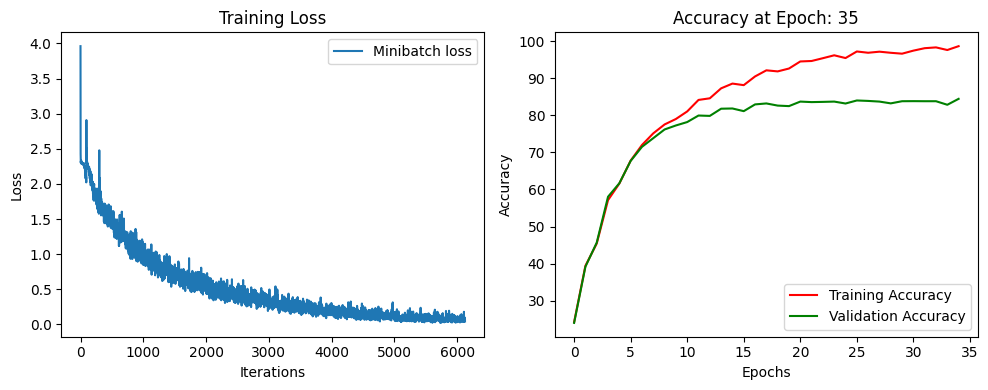

Epoch: 036/050 | Batch 0000/0175 | Loss: 0.0229
Epoch: 036/050 | Batch 0100/0175 | Loss: 0.0923
Epoch: 036/050 | Train Acc: 98.15% | Validation Acc: 83.20% | Precision: 0.8330 | Recall: 0.8328 | F1: 0.8303
Epoch: 037/050 | Batch 0000/0175 | Loss: 0.0669
Epoch: 037/050 | Batch 0100/0175 | Loss: 0.0917
Epoch: 037/050 | Train Acc: 98.21% | Validation Acc: 83.58% | Precision: 0.8430 | Recall: 0.8357 | F1: 0.8366
Epoch: 038/050 | Batch 0000/0175 | Loss: 0.0487
Epoch: 038/050 | Batch 0100/0175 | Loss: 0.0092
Epoch: 038/050 | Train Acc: 98.92% | Validation Acc: 84.40% | Precision: 0.8451 | Recall: 0.8447 | F1: 0.8429
Epoch: 039/050 | Batch 0000/0175 | Loss: 0.0363
Epoch: 039/050 | Batch 0100/0175 | Loss: 0.0346
Epoch: 039/050 | Train Acc: 98.57% | Validation Acc: 85.00% | Precision: 0.8535 | Recall: 0.8505 | F1: 0.8508
Epoch: 040/050 | Batch 0000/0175 | Loss: 0.0307
Epoch: 040/050 | Batch 0100/0175 | Loss: 0.1059
Epoch: 040/050 | Train Acc: 98.58% | Validation Acc: 84.18% | Precision: 0.8460 

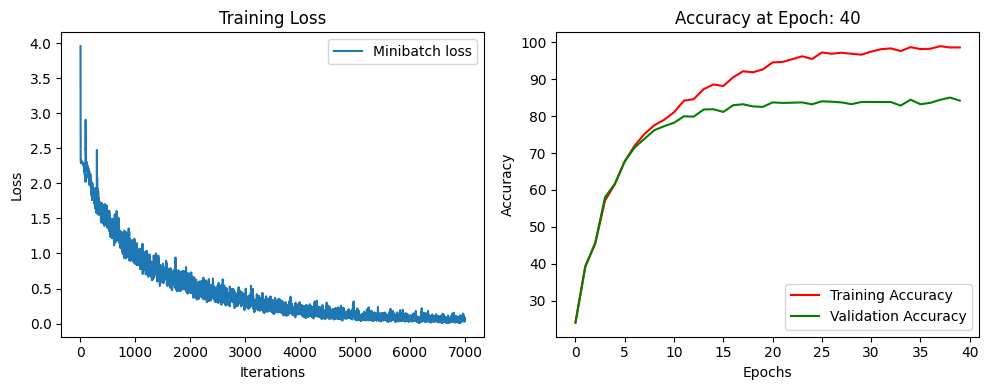

Epoch: 041/050 | Batch 0000/0175 | Loss: 0.0611
Epoch: 041/050 | Batch 0100/0175 | Loss: 0.0556
Epoch: 041/050 | Train Acc: 98.79% | Validation Acc: 84.72% | Precision: 0.8556 | Recall: 0.8471 | F1: 0.8501
Epoch: 042/050 | Batch 0000/0175 | Loss: 0.0134
Epoch: 042/050 | Batch 0100/0175 | Loss: 0.0365
Epoch: 042/050 | Train Acc: 99.18% | Validation Acc: 84.92% | Precision: 0.8498 | Recall: 0.8499 | F1: 0.8486
Epoch: 043/050 | Batch 0000/0175 | Loss: 0.0125
Epoch: 043/050 | Batch 0100/0175 | Loss: 0.0339
Epoch: 043/050 | Train Acc: 99.00% | Validation Acc: 84.84% | Precision: 0.8472 | Recall: 0.8491 | F1: 0.8472
Epoch: 044/050 | Batch 0000/0175 | Loss: 0.0438
Epoch: 044/050 | Batch 0100/0175 | Loss: 0.0609
Epoch: 044/050 | Train Acc: 98.89% | Validation Acc: 84.56% | Precision: 0.8505 | Recall: 0.8456 | F1: 0.8453
Epoch: 045/050 | Batch 0000/0175 | Loss: 0.0379
Epoch: 045/050 | Batch 0100/0175 | Loss: 0.0455
Epoch: 045/050 | Train Acc: 99.30% | Validation Acc: 85.16% | Precision: 0.8526 

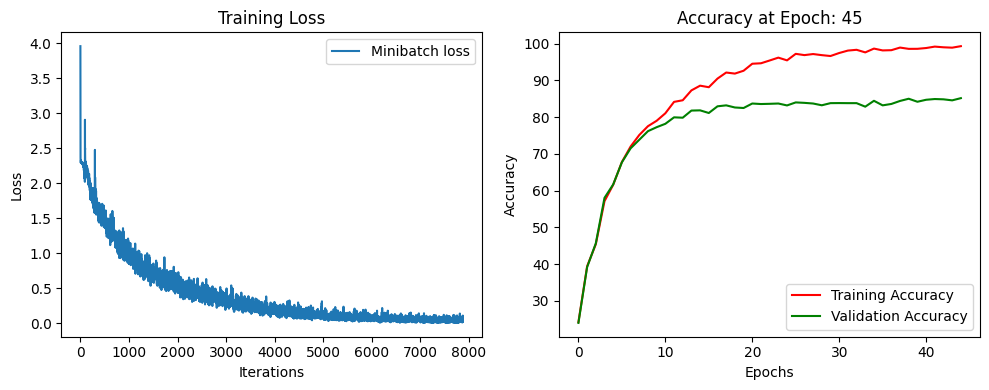

Epoch: 046/050 | Batch 0000/0175 | Loss: 0.0139
Epoch: 046/050 | Batch 0100/0175 | Loss: 0.0208
Epoch: 046/050 | Train Acc: 99.23% | Validation Acc: 84.82% | Precision: 0.8531 | Recall: 0.8485 | F1: 0.8500
Epoch: 047/050 | Batch 0000/0175 | Loss: 0.0444
Epoch: 047/050 | Batch 0100/0175 | Loss: 0.0407
Epoch: 047/050 | Train Acc: 98.51% | Validation Acc: 83.68% | Precision: 0.8534 | Recall: 0.8358 | F1: 0.8404
Epoch: 048/050 | Batch 0000/0175 | Loss: 0.0233
Epoch: 048/050 | Batch 0100/0175 | Loss: 0.0221
Epoch: 048/050 | Train Acc: 98.84% | Validation Acc: 84.62% | Precision: 0.8479 | Recall: 0.8465 | F1: 0.8453
Epoch: 049/050 | Batch 0000/0175 | Loss: 0.0237
Epoch: 049/050 | Batch 0100/0175 | Loss: 0.0300
Epoch: 049/050 | Train Acc: 99.15% | Validation Acc: 84.42% | Precision: 0.8427 | Recall: 0.8451 | F1: 0.8428
Epoch: 050/050 | Batch 0000/0175 | Loss: 0.0601
Epoch: 050/050 | Batch 0100/0175 | Loss: 0.0630
Epoch: 050/050 | Train Acc: 99.00% | Validation Acc: 84.60% | Precision: 0.8466 

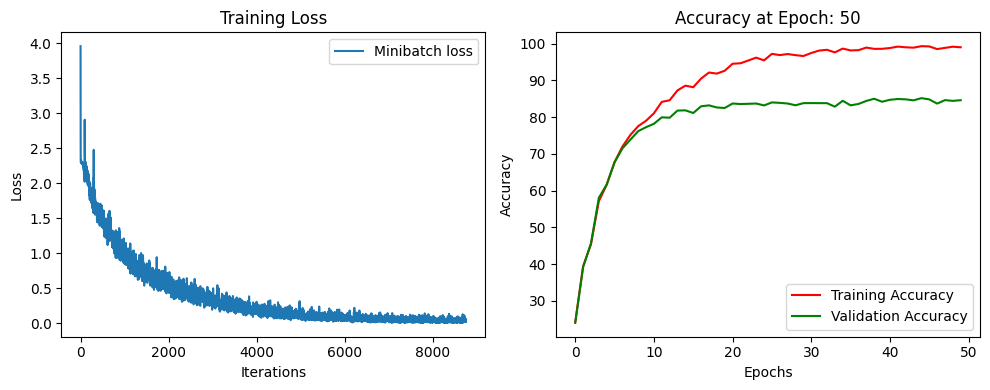

Total Training Time: 84.94 min
Test Metrics | Accuracy: 83.72% | Precision: 0.8380 | Recall: 0.8372 | F1: 0.8355


In [8]:
from models.VGG_16 import VGG16

model_16 = VGG16(num_classes=10)
model_16 = model_16.to(DEVICE)

optimizer = torch.optim.SGD(model_16.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)
minibatch_loss_list_16, train_acc_list_16, valid_acc_list_16, valid_precision_list_16, valid_recall_list_16, valid_f1_list_16, test_acc_16, test_precision_16, test_recall_16, test_f1_16 = train_model(
    model=model_16,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader_64,
    valid_loader=valid_loader_64,
    test_loader=test_loader_64,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

In [18]:
## Save the results

save_model(model_16, 'VGG16', results_dir+'/models')


data_lists_16 = [minibatch_loss_list_16, train_acc_list_16, valid_acc_list_16, valid_precision_list_16,
                 valid_recall_list_16, valid_f1_list_16, [test_acc_16], [test_precision_16], [test_recall_16],
                 [test_f1_16]]
metrics_labels = [
    'minibatch_loss',
    'train_acc',
    'valid_acc',
    'valid_precision',
    'valid_recall',
    'valid_f1',
    'test_acc',
    'test_precision',
    'test_recall',
    'test_f1'
]

save_metrics(data_lists_16, metrics_labels, 'VGG16', results_dir)


Model VGG16 saved successfully at /content/drive/My Drive/Colab Notebooks/II142X-Results/models/model_VGG16.pth
Saved minibatch_loss for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/minibatch_loss_VGG16.csv
Saved train_acc for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/train_acc_VGG16.csv
Saved valid_acc for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/valid_acc_VGG16.csv
Saved valid_precision for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/valid_precision_VGG16.csv
Saved valid_recall for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/valid_recall_VGG16.csv
Saved valid_f1 for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/valid_f1_VGG16.csv
Saved test_acc for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results/test_acc_VGG16.csv
Saved test_precision for Model VGG16 at /content/drive/My Drive/Colab Notebooks/II142X-Results

In [ ]:
from models.VGG_23 import VGG23

model_23 = VGG23(num_classes=10)
model_23 = model_23.to(DEVICE)

optimizer = torch.optim.SGD(model_23.parameters(), momentum=0.9, lr=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                       factor=0.1,
                                                       mode='max',
                                                       verbose=True)

minibatch_loss_list_23, train_acc_list_23, valid_acc_list_23, valid_precision_list_23, valid_recall_list_23, valid_f1_list_23, test_acc_23, test_precision_23, test_recall_23, test_f1_23 = train_model(
    model=model_23,
    num_epochs=NUM_EPOCHS,
    train_loader=train_loader_128,
    valid_loader=valid_loader_128,
    test_loader=test_loader_128,
    optimizer=optimizer,
    device=DEVICE,
    scheduler=scheduler,
    scheduler_on='valid_acc',
    logging_interval=100)

In [ ]:
## Save the results

save_model(model_23, 'VGG23', results_dir+'/models')

data_lists_23 = [
    minibatch_loss_list_23,
    train_acc_list_23,
    valid_acc_list_23,
    valid_precision_list_23,
    valid_recall_list_23,
    valid_f1_list_23,
    [test_acc_23],
    [test_precision_23],
    [test_recall_23],
    [test_f1_23]
]
metrics_labels = [
    'minibatch_loss',
    'train_acc',
    'valid_acc',
    'valid_precision',
    'valid_recall',
    'valid_f1',
    'test_acc',
    'test_precision',
    'test_recall',
    'test_f1'
]

save_metrics(data_lists_23, metrics_labels, 'VGG23', results_dir)


## Visualizing the results

In [ ]:
## Plotting the results

plot_metric(valid_precision_list_16, valid_precision_list_23, 'Precision', results_dir)
plot_metric(valid_recall_list_16, valid_recall_list_23, 'Recall', results_dir)
plot_metric(valid_f1_list_16, valid_f1_list_23, 'F1 score', results_dir)
plot_accuracy(train_acc_list_16, valid_acc_list_16, train_acc_list_23, valid_acc_list_23, results_dir)
plot_training_loss(minibatch_loss_list_16, minibatch_loss_list_23, NUM_EPOCHS, len(train_loader_128), results_dir, 100)


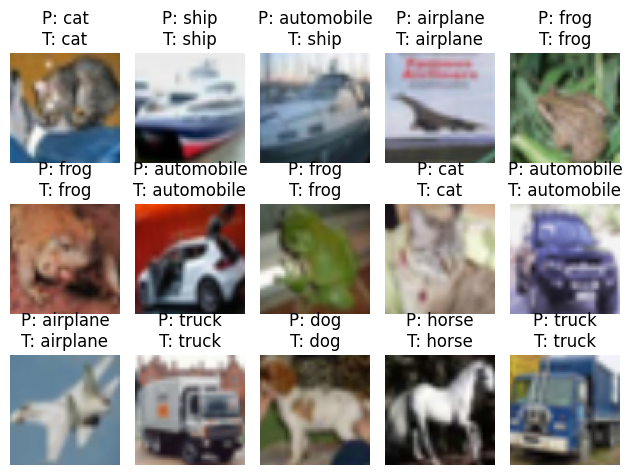

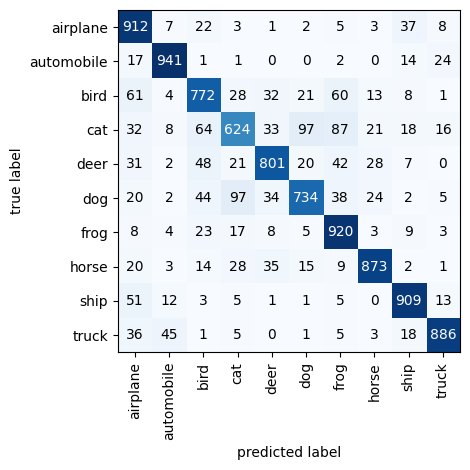

In [19]:
## Confusion matrix and examples VGG 16
model_16.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model_16, data_loader=test_loader_64, unnormalizer=unnormalizer, class_dict=class_dict)

mat = compute_confusion_matrix(model=model_16, data_loader=test_loader_64, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())

In [ ]:
## Confusion matrix and examples VGG 23
model_23.cpu()
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

show_examples(model=model_23, data_loader=test_loader_128, unnormalizer=unnormalizer, class_dict=class_dict)

mat = compute_confusion_matrix(model=model_23, data_loader=test_loader_128, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
